# Technical Analysis and Backtesting Framework for Stock Trading

In [1]:
!pip install --quiet yfinance mplfinance
import yfinance as yf
import pandas as pd
import numpy as np
import os

def fetch_data (ticker, start = "2015-01-01", end = "2024-12-31", cache = True):
    filename = f"{ticker}.csv"
    if cache and os.path.exists (filename):
        df = pd.read_csv (filename, index_col = "Date", parse_dates = True)
        return df
    df = yf.download (ticker, start = start, end = end, progress = False, auto_adjust = False)
    if isinstance (df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values (0)
    df.index.name = "Date"
    df.to_csv (filename)
    return df

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


In [2]:
tickers = ["TCS.NS", "INFY.NS", "RELIANCE.NS", "HDFCBANK.NS", "ITC.NS"]
stock_data = {}
for t in tickers:
    print (f"Fetching data for {t}...")
    stock_data [t] = fetch_data (t)
print ("\n Available Stocks:")
for i, t in enumerate (tickers, 1):
    print (f"{i}. {t}")
selected_index = int (input ("Choose a stock by number (1 - 5): "))
ticker = tickers [selected_index - 1]
df = stock_data [ticker]

Fetching data for TCS.NS...
Fetching data for INFY.NS...
Fetching data for RELIANCE.NS...
Fetching data for HDFCBANK.NS...
Fetching data for ITC.NS...

 Available Stocks:
1. TCS.NS
2. INFY.NS
3. RELIANCE.NS
4. HDFCBANK.NS
5. ITC.NS
Choose a stock by number (1 - 5): 1


In [3]:
class SMAIndicator:
    def __init__ (self, window): self.window = window
    def calculate (self, df): return df ['Close'].rolling (window = self.window).mean ()

class EMAIndicator:
    def __init__ (self, window): self.window = window
    def calculate (self, df): return df ['Close'].ewm (span = self.window, adjust = False).mean ()

class RSIIndicator:
    def __init__ (self, window = 14): self.window = window
    def calculate (self, df):
        delta = df ['Close'].diff ()
        gain = (delta.where (delta > 0, 0)).rolling (window = self.window).mean ()
        loss = (-delta.where (delta < 0, 0)).rolling (window = self.window).mean ()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

class MACDIndicator:
    def __init__(self, fast = 12, slow = 26, signal = 9):
        self.fast, self.slow, self.signal = fast, slow, signal
    def calculate (self, df):
        ema_fast = df ['Close'].ewm (span = self.fast, adjust = False).mean ()
        ema_slow = df ['Close'].ewm (span = self.slow, adjust = False).mean ()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm (span = self.signal, adjust = False).mean ()
        return macd, signal_line

class VWAPIndicator:
    def calculate (self, df: pd.DataFrame) -> pd.Series:
        vwap = (df ['Close'] * df['Volume']).cumsum () / df['Volume'].cumsum ()
        return vwap

In [4]:
from abc import ABC, abstractmethod
class BaseStrategy (ABC):
    @abstractmethod
    def generate_signals (self, df: pd.DataFrame) -> pd.DataFrame:
        pass

class MovingAverageCrossoverStrategy (BaseStrategy):
    def __init__ (self, short_window = 50, long_window = 200):
        self.short_window = short_window
        self.long_window = long_window
    def generate_signals (self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy ()
        df ['SMA_50'] = df['Close'].rolling (window = self.short_window).mean ()
        df ['SMA_200'] = df['Close'].rolling (window = self.long_window).mean ()
        df ['Signal'] = 0
        df.loc [df ['SMA_50'] > df ['SMA_200'], 'Signal'] = 1
        df.loc [df ['SMA_50'] < df ['SMA_200'], 'Signal'] = - 1
        df ['Position'] = df ['Signal'].shift ()
        return df

class RSIMACDStrategy (BaseStrategy):
    def __init__ (self, rsi_window = 14, macd_fast = 12, macd_slow = 26, macd_signal = 9):
        self.rsi_window, self.macd_fast, self.macd_slow, self.macd_signal = rsi_window, macd_fast, macd_slow, macd_signal
    def generate_signals (self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy ()
        delta = df ['Close'].diff ()
        gain = delta.clip (lower = 0)
        loss = -delta.clip (upper = 0)
        avg_gain = gain.rolling (window = self.rsi_window).mean ()
        avg_loss = loss.rolling (window = self.rsi_window).mean ()
        rs = avg_gain / avg_loss
        df ['RSI'] = 100 - (100 / (1 + rs))
        ema_fast = df ['Close'].ewm (span = self.macd_fast, adjust = False).mean ()
        ema_slow = df ['Close'].ewm (span = self.macd_slow, adjust = False).mean ()
        df ['MACD'] = ema_fast - ema_slow
        df ['MACD_Signal'] = df ['MACD'].ewm (span = self.macd_signal, adjust = False).mean ()
        df ['Signal'] = 0
        buy = (df ['RSI'] < 30) & (df ['MACD'] > df ['MACD_Signal']) & (df ['MACD'].shift (1) <= df ['MACD_Signal'].shift (1))
        sell = (df ['RSI'] > 70) & (df ['MACD'] < df ['MACD_Signal']) & (df ['MACD'].shift (1) >= df ['MACD_Signal'].shift (1))
        df.loc [buy, 'Signal'] = 1
        df.loc [sell, 'Signal'] = -1
        df ['Position'] = df ['Signal'].shift ()
        return df

In [5]:
strategy_choice = input ("Choose strategy: 'SMA', 'RSI + MACD', or 'Combined': ")
if strategy_choice == 'SMA':
    strategy = MovingAverageCrossoverStrategy ()
    strategy_name = "SMA 50/200 Crossover"
elif strategy_choice == 'RSI + MACD':
    strategy = RSIMACDStrategy ()
    strategy_name = "RSI + MACD Strategy"
elif strategy_choice == 'Combined':
    class CombinedStrategy (BaseStrategy):
        def __init__ (self):
            self.sma = MovingAverageCrossoverStrategy ()
            self.rsi_macd = RSIMACDStrategy ()

        def generate_signals (self, df):
            df1 = self.sma.generate_signals (df)
            df2 = self.rsi_macd.generate_signals (df1)
            df2 ['Signal'] = df1 ['Signal'] + df2 ['Signal']
            df2 ['Signal'] = df2 ['Signal'].clip (-1, 1)
            df2 ['Position'] = df2 ['Signal'].shift ()
            return df2
    strategy = CombinedStrategy ()
    strategy_name = "SMA + RSI / MACD combined strategy"
else:
    raise ValueError ("Invalid strategy selected")

Choose strategy: 'SMA', 'RSI + MACD', or 'Combined': Combined


📈 Strategy Report
-------------------
Stock: TCS.NS
Strategy: SMA + RSI / MACD combined strategy
Total Trades: 0
Win Rate: 0.0 %
Final Portfolio Value: ₹ 100,000.00
CAGR: 0.00 %
Sharpe Ratio: 0.00
Max Drawdown: 0.00 %


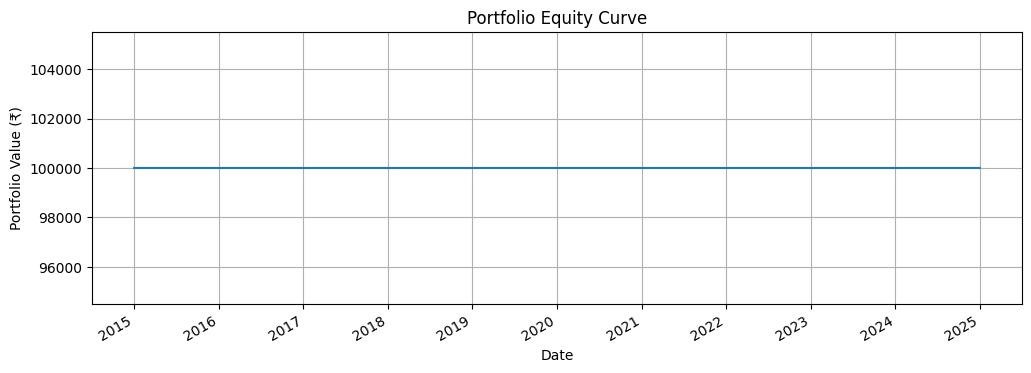

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
class Backtester:
    def __init__ (self, initial_capital = 100000, position_size = 100):
        self.initial_capital = initial_capital
        self.position_size = position_size
        self.trades_log = []

    def run (self, df):
        df = df.copy ()
        df ['Holdings'] = 0
        df ['Cash'] = self.initial_capital
        df ['Portfolio'] = self.initial_capital
        in_position = False
        for i in range (1, len (df)):
            row = df.iloc [i]
            date = row.name
            price = row ['Close']
            if row ['Signal'] == 1 and not in_position:
                cost = self.position_size * price
                if df.at [date, 'Cash'] >= cost:
                    df.at [date, 'Cash'] -= cost
                    df.at [date, 'Holdings'] = self.position_size * price
                    self.trades_log.append ({'Date': date, 'Action': 'BUY', 'Price': price})
                    in_position = True
            elif row ['Signal'] == -1 and in_position:
                proceeds = self.position_size * price
                df.at [date, 'Cash'] += proceeds
                df.at [date, 'Holdings'] = 0
                self.trades_log.append ({'Date': date, 'Action': 'SELL', 'Price': price})
                in_position = False
            df.at [date, 'Portfolio'] = df.at [date, 'Cash'] + df.at [date, 'Holdings']
        return df

    def get_trades_log (self):
        return pd.DataFrame (self.trades_log)

class BacktestReport:
    def __init__ (self, df, trades_df, ticker, strategy_name, initial_capital = 100000):
        self.df = df
        self.trades_df = trades_df
        self.ticker = ticker
        self.strategy_name = strategy_name
        self.initial_capital = initial_capital

    def print_report (self):
        returns = self.df ['Portfolio'].pct_change ().dropna ()
        final_value = self.df ['Portfolio'].iloc [-1]
        cagr = ((final_value / self.initial_capital) ** (1 / (len(self.df) / 252))) - 1
        sharpe = np.mean (returns) / np.std (returns) * np.sqrt (252) if np.std (returns) != 0 else 0
        drawdown = (self.df ['Portfolio'] / self.df ['Portfolio'].cummax ()) - 1
        max_drawdown = drawdown.min ()
        wins = 0
        losses = 0
        for i in range (1, len (self.trades_df), 2):
            if self.trades_df.iloc [i]['Action'] == 'SELL':
                buy_price = self.trades_df.iloc [i - 1]['Price']
                sell_price = self.trades_df.iloc [i]['Price']
                if sell_price > buy_price:
                    wins += 1
                else:
                    losses += 1
        total_trades = wins + losses
        win_rate = (wins / total_trades * 100) if total_trades > 0 else 0
        print ("📈 Strategy Report")
        print ("-" * 19)
        print (f"Stock: {ticker}")
        print (f"Strategy: {strategy_name}")
        print (f"Total Trades: {total_trades}")
        print (f"Win Rate: {win_rate:.1f} %")
        print (f"Final Portfolio Value: ₹ {final_value:,.2f}")
        print (f"CAGR: {cagr*100:.2f} %")
        print (f"Sharpe Ratio: {sharpe:.2f}")
        print (f"Max Drawdown: {max_drawdown*100:.2f} %")

    def plot_equity_curve (self):
        self.df ['Portfolio'].plot (figsize = (12, 4), title = 'Portfolio Equity Curve', ylabel = 'Portfolio Value (₹)')
        plt.grid (True)
        plt.show ()


df_signals = strategy.generate_signals (df)
backtester = Backtester (initial_capital = 100000, position_size = 100)
df_backtested = backtester.run (df_signals)
report = BacktestReport (df = df_backtested, trades_df = backtester.get_trades_log (), ticker = ticker, strategy_name = strategy_name)
report.print_report ()
report.plot_equity_curve ()

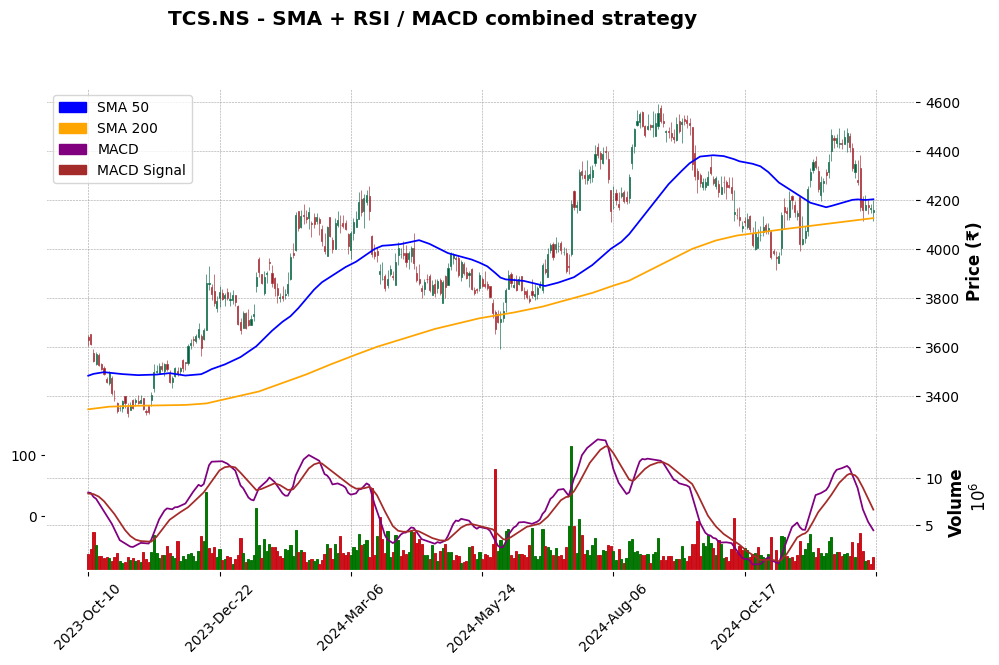

In [7]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_candlestick_with_signals (df, ticker, trades_df = None, strategy_name = "Strategy"):
    df = df.copy ().tail (300)
    df ['Buy'] = np.nan
    df ['Sell'] = np.nan
    if trades_df is not None and not trades_df.empty:
        trades_df = trades_df.copy ()
        trades_df ['Date'] = pd.to_datetime (trades_df ['Date'])
        trades_df.set_index('Date', inplace = True)
        for date, row in trades_df.iterrows ():
            if date in df.index:
                if row ['Action'] == 'BUY':
                    df.at [date, 'Buy'] = df.at [date, 'Close']
                elif row ['Action'] == 'SELL':
                    df.at [date, 'Sell'] = df.at [date, 'Close']
    apds = []
    legend_elements = []
    if 'SMA_50' in df.columns and df ['SMA_50'].notna ().any ():
      apds.append (mpf.make_addplot(df ['SMA_50'], color = 'blue'))
      legend_elements.append (mpatches.Patch (color = 'blue', label = 'SMA 50'))

    if 'SMA_200' in df.columns and df ['SMA_200'].notna ().any ():
      apds.append (mpf.make_addplot (df ['SMA_200'], color = 'orange'))
      legend_elements.append (mpatches.Patch (color = 'orange', label = 'SMA 200'))

    if 'MACD' in df.columns and df ['MACD'].notna ().any ():
      apds.append (mpf.make_addplot (df ['MACD'], panel = 1, color = 'purple'))
      legend_elements.append (mpatches.Patch (color = 'purple', label = 'MACD'))

    if 'MACD_Signal' in df.columns and df ['MACD_Signal'].notna ().any ():
      apds.append (mpf.make_addplot (df ['MACD_Signal'], panel = 1, color = 'brown'))
      legend_elements.append (mpatches.Patch (color = 'brown', label = 'MACD Signal'))

    fig, axes = mpf.plot (df, type = 'candle', style = 'charles', addplot = apds, volume = True, title = f"{ticker} - {strategy_name}", ylabel = 'Price (₹)', ylabel_lower = 'Volume', figratio = (14, 8), figscale = 1.2, returnfig = True)
    if legend_elements:
        axes [0].legend (handles = legend_elements)
    plt.show ()
trades_df = backtester.get_trades_log ()
plot_candlestick_with_signals (df_backtested, ticker = ticker, trades_df = trades_df, strategy_name = strategy_name)

In [8]:
import yfinance as yf
import pandas as pd
import time

def poll_live_price (ticker, interval = 10, max_iterations = 10):
    print (f"\n Polling {ticker} every {interval} seconds \n")

    for _ in range (max_iterations):
        data = yf.download (ticker, period = "1d", interval = "1m", progress = False, auto_adjust = False)
        if not data.empty:
            last = data.iloc [-1]
            try:
                open_price = float (last ['Open'].iloc [0]) if isinstance (last ['Open'], pd.Series) else float (last ['Open'])
                close_price = float (last ['Close'].iloc [0]) if isinstance (last ['Close'], pd.Series) else float (last ['Close'])
                timestamp = last.name.to_pydatetime ().strftime ('%H:%M')
                print (f"{timestamp} | Open: {open_price:.2f}, Close: {close_price:.2f}")
            except Exception as e:
                print (f"Skipping due to error: {e}")
        else:
            print ("No data received.")
        time.sleep (interval)
poll_live_price (ticker = ticker, interval = 10, max_iterations = 10)


 Polling TCS.NS every 10 seconds 

09:59 | Open: 3423.40, Close: 3423.30
09:59 | Open: 3423.40, Close: 3423.30
09:59 | Open: 3423.40, Close: 3423.30
09:59 | Open: 3423.40, Close: 3423.30
09:59 | Open: 3423.40, Close: 3423.30
09:59 | Open: 3423.40, Close: 3423.30
09:59 | Open: 3423.40, Close: 3423.30
09:59 | Open: 3423.40, Close: 3423.30
09:59 | Open: 3423.40, Close: 3423.30
09:59 | Open: 3423.40, Close: 3423.30
